# Seicmic data semantic semantic segmentation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from albumentations import ElasticTransform

from keras.models import Model
from keras.layers import*
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import cv2

C:\Users\Vaneg\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Baseline
For baseline we used U-Net model.

U-Net is a convolutional neural network that was developed for biomedical image segmentation. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations.

### U-Net

In [2]:
def unet(pretrained_weights = None,input_size = (768,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    #drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    #drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)
    #parallel_model = multi_gpu_model(model, gpus=2)
    #parallel_model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
    #model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

## Input data

For implementation of main idei Netherlands F3 Block Dataset was used.

Load data

In [4]:
train_x = np.load('C:/Users/Vaneg/Desktop/contests/aramco_2019/data/train/train_seismic.npy') 
train_y = np.load('C:/Users/Vaneg/Desktop/contests/aramco_2019/data/train/train_labels.npy')

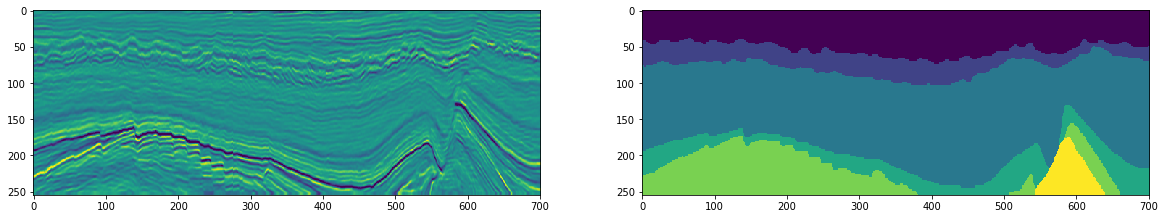

In [5]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.imshow(train_x[0,:,:].transpose())

plt.subplot(1,2,2)
plt.imshow(train_y[0,:,:].transpose())


Resize data

In [ ]:
def resize_data(a,imsize_x, imsize_y, num_of_img):
    a_Resized=[]
    n = num_of_img
    for i in range(n):
        img=a[i,:,:]
        a_Resized.append(cv2.resize(img, (imsize_x, imsize_y), interpolation=cv2.INTER_NEAREST))
        i=i+1
    #a_Resized = np.array(a_Resized)
    return np.array(a_Resized)

In [6]:
imsize_x = 256
imsize_y = 768
bands = 1


In [7]:
train_x_resize = resize_data(train_x, imsize_x, imsize_y, 401)
train_y_resize = resize_data(train_y, imsize_x, imsize_y, 401)
print(train_x_resize.shape)
print(train_y_resize.shape)

(401, 768, 256)
(401, 768, 256)


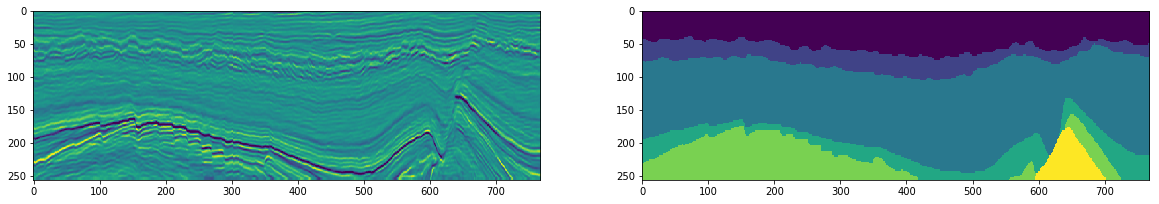

In [8]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.imshow(train_x_resize[0,:,:].transpose())

plt.subplot(1,2,2)
plt.imshow(train_y_resize[0,:,:].transpose())


Plotting calass labels

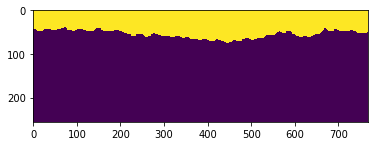

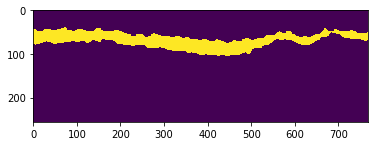

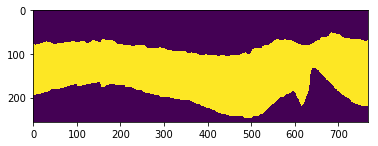

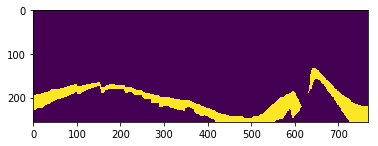

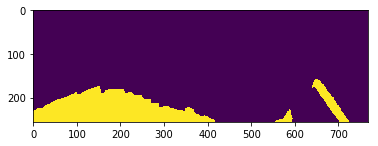

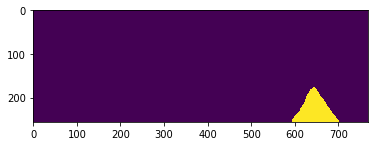

In [10]:
for i in range(6):
    plt.imshow((train_y_resize==i)[0,:,:].transpose())
    plt.show()

## Train U-Net

In [11]:
batch_size=4
epochs=10
verbose=1
validation_split=0.1

In [12]:
x = np.stack((train_x_resize,), axis = -1) 

In [13]:
y_bin = (train_y_resize==0)*1

In [15]:
y = np.stack((y_bin,), axis = -1) 

In [17]:
model = unet()

C:\Users\Vaneg\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [18]:
model.fit(x,y, batch_size=batch_size, epochs=epochs, verbose=verbose,
                validation_split=validation_split)

Train on 360 samples, validate on 41 samples
Epoch 1/10
360/360 [==============================] - 62s 172ms/step - loss: 0.5209 - acc: 0.7264 - val_loss: 0.2769 - val_acc: 0.9667
Epoch 2/10
360/360 [==============================] - 54s 151ms/step - loss: 0.1956 - acc: 0.9909 - val_loss: 0.2943 - val_acc: 0.9877
Epoch 3/10
360/360 [==============================] - 56s 156ms/step - loss: 0.2637 - acc: 0.9416 - val_loss: 0.2250 - val_acc: 0.9815
Epoch 4/10
360/360 [==============================] - 57s 158ms/step - loss: 0.1762 - acc: 0.9885 - val_loss: 0.2035 - val_acc: 0.9909
Epoch 5/10
360/360 [==============================] - 56s 157ms/step - loss: 0.1576 - acc: 0.9951 - val_loss: 0.1940 - val_acc: 0.9910
Epoch 6/10
360/360 [==============================] - 57s 158ms/step - loss: 0.1472 - acc: 0.9955 - val_loss: 0.1797 - val_acc: 0.9928
Epoch 7/10
360/360 [==============================] - 57s 158ms/step - loss: 0.1378 - acc: 0.9958 - val_loss: 0.1699 - val_acc: 0.9929
Epoch 8/10

Validation accuracy is more than 99%

In [19]:
model.save('unet_10ep_class0.h5')

### Load test data

In [20]:
test_x = np.load('C:/Users/Vaneg/Desktop/contests/aramco_2019/data/test_once/test1_seismic.npy') 
test_y = np.load('C:/Users/Vaneg/Desktop/contests/aramco_2019/data/test_once/test1_labels.npy')

test_x_resize = resize_data(train_x, imsize_x, imsize_y, 20)
test_y_resize = resize_data(train_y, imsize_x, imsize_y, 20)

In [21]:
y_test = np.stack((test_x_resize,), axis = -1) 

### Prediction

In [22]:
pred = model.predict(y_test)

In [23]:
pred.shape

(20, 768, 256, 1)

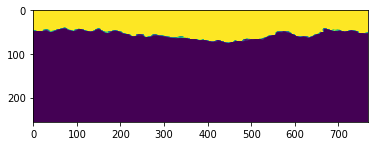

In [24]:
plt.imshow(((pred[0,:,:,0])).transpose())

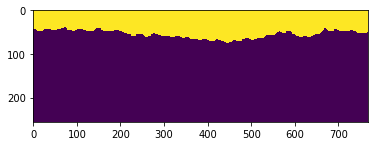

In [29]:
plt.imshow(((test_y_resize[0,:,:])==0).transpose())

Text(0.5,1,'Ground Trurh')

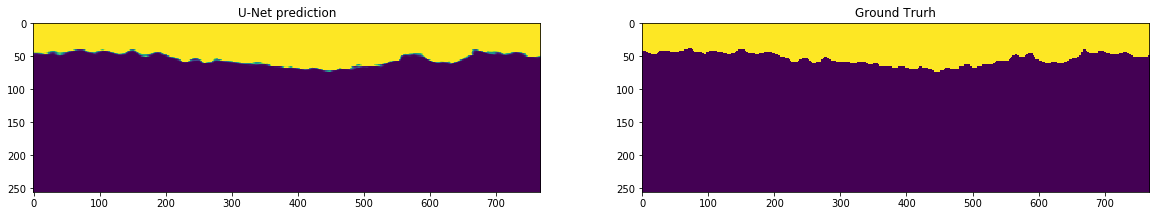

In [32]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.imshow(((pred[0,:,:,0])).transpose())
plt.title('U-Net prediction')

plt.subplot(1,2,2)
plt.imshow(((test_y_resize[0,:,:])==0).transpose())
plt.title('Ground Trurh')